In [19]:
import numpy as np
import scipy as sp
import scipy.fftpack
from matplotlib import pyplot as plt
import scipy.io
import math as mt

In [20]:
rootfolder = '..'

Generating 1-D DCT basis
------------------------


In [21]:
M = 128 # signal dimension
N = M # nr of atoms in the basis (this will be different when using redundant set of generators)

D = np.zeros((M, N)) # matrix containing the DCT basis (a DCT function in each column)
DCT = np.eye(M) # matrix containing the standard basis (a kronecker delta in each column)

c = 0
for r in range(0,M):
    DCT[r,c] = mt.sqrt(1/M)*mt.cos(c*mt.pi*((2*r + 1)/(2*M)))
for c in range(1, M):
    for r in range(0,M):
        DCT[r,c] = mt.sqrt(2/M)*mt.cos(c*mt.pi*((2*r + 1)/(2*M)))
# normalize the DCT basis
for c in range(0,N):
    D[:,c] = DCT[:,c]/np.linalg.norm(DCT[:,c])


Display an atom of the dct basis

Text(0.5, 1.0, 'element: 25 from the DCT basis')

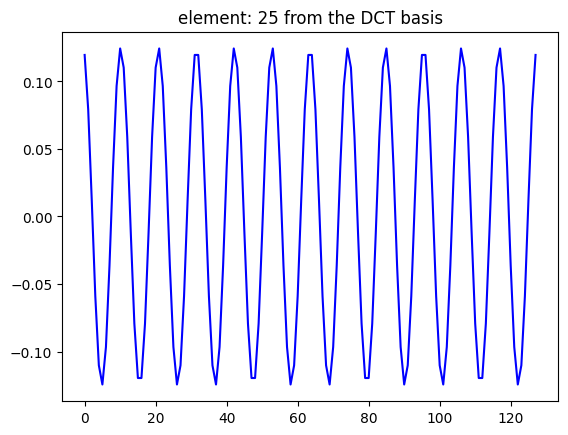

In [22]:
k = 24
plt.figure()
plt.plot(DCT[:, k], 'b')
plt.title(f'element: {k+1} from the DCT basis')

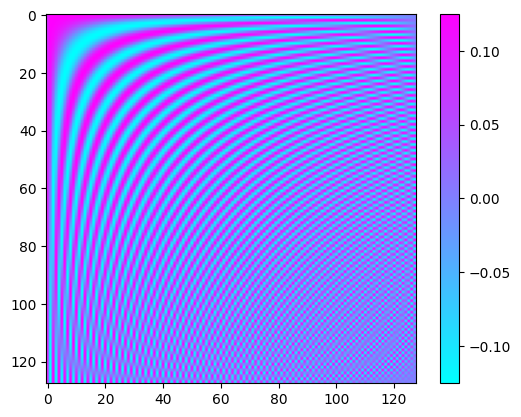

In [23]:
plt.imshow(DCT, cmap='cool')  
plt.colorbar()  
plt.show()

Check orthogonality

In [24]:
is_DCT_orth = np.allclose(np.identity(128), np.dot(DCT, np.transpose(DCT)), atol=0.01)
print(f'DCT dictionary is orthogonal: {is_DCT_orth}')
# The DCT is orthogonal if we assume a tollerance of at 1%. If instead we want to have stronger evidences (lower tolerance) the DCT will
# be classified as non orthogonal.

DCT dictionary is orthogonal: True


Display the basis in the matrix

Text(0.5, 1.0, 'DCT basis, atoms in the column')

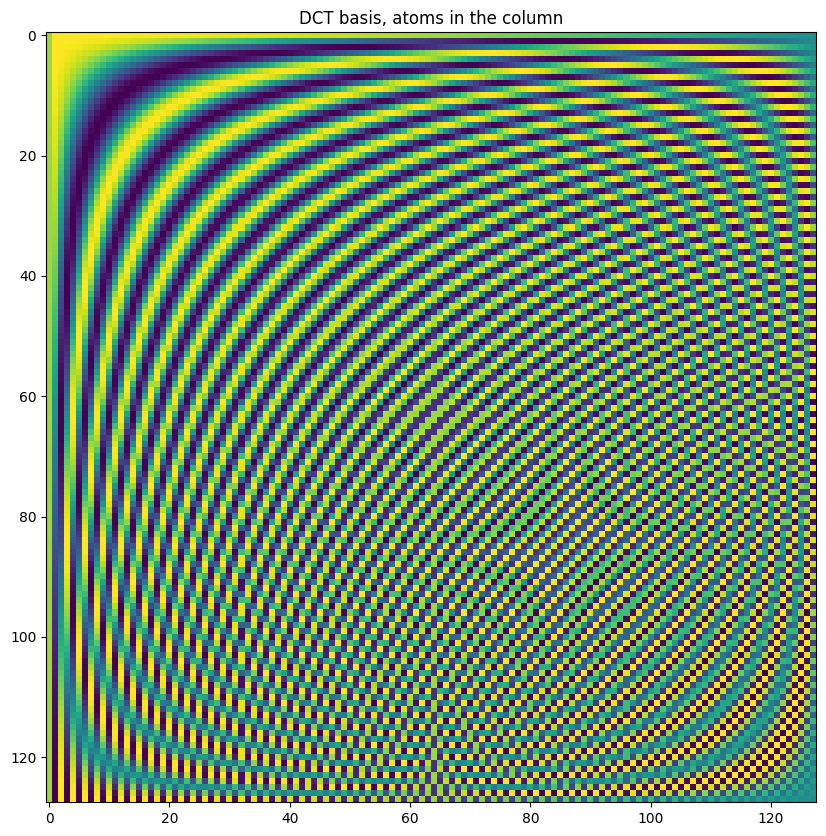

In [25]:
plt.figure(figsize=(10,10))
plt.imshow(DCT)
plt.title('DCT basis, atoms in the column')

Generate 1D DCT basis using the function idct
---------------------------------------------
idct is the inverse dct transform stack this in the matrix D

In [26]:
for k in range(M):
    # define the atom
    a = np.zeros(M)
    a[k] = 1
    D[:, k] = sp.fftpack.idct(a, norm='ortho')
# normalize the DCT basis
for c in range(0,N):
    D[:,c] = D[:,c]/np.linalg.norm(D[:,c])


Display the basis in the matrix

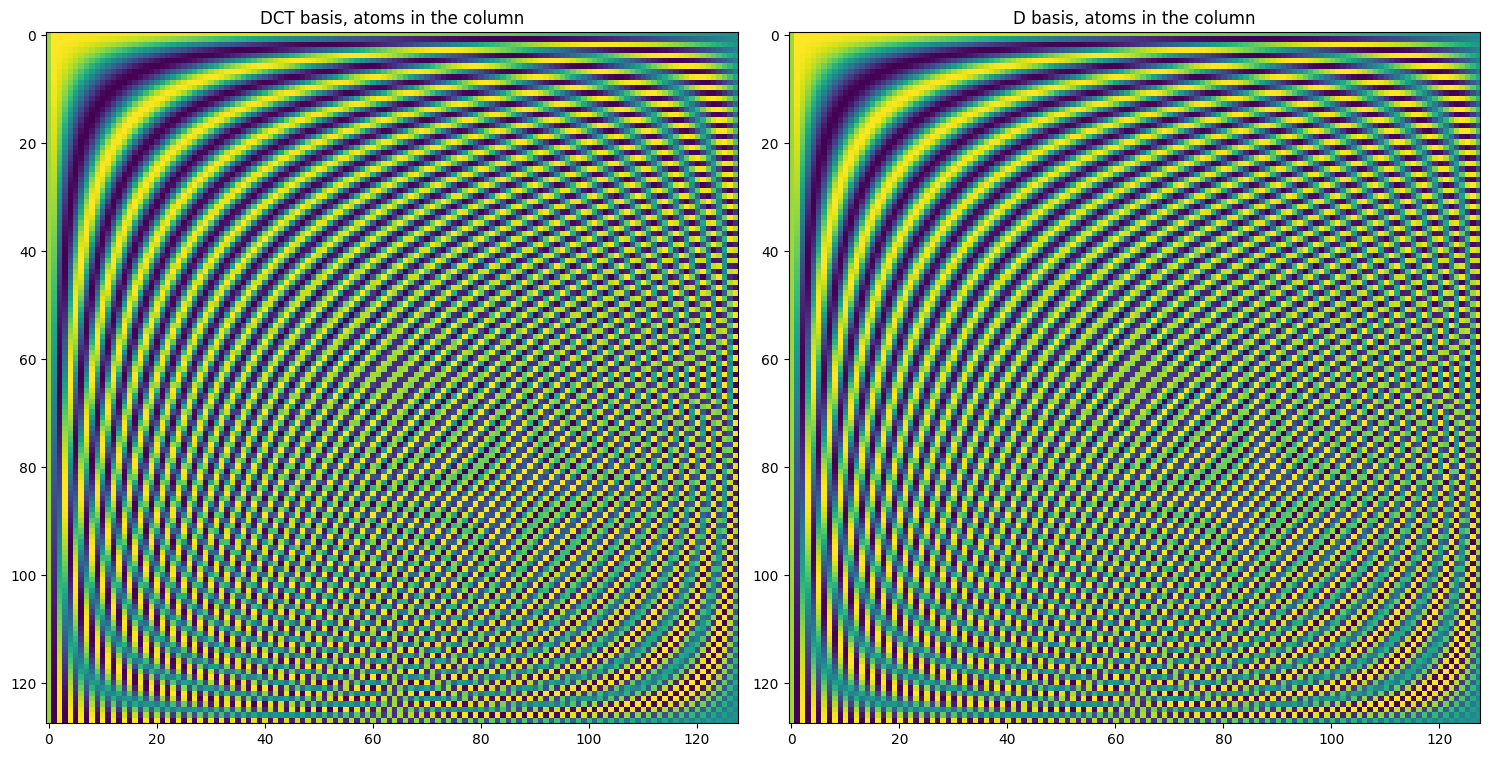

In [27]:
plt.figure(figsize=(15,10))

plt.subplot(1, 2, 1)
plt.imshow(DCT)
plt.title('DCT basis, atoms in the column')
plt.subplot(1, 2, 2)
plt.imshow(D)
plt.title('D basis, atoms in the column')
plt.tight_layout()  # Regola automaticamente la disposizione dei grafici per evitare sovrapposizioni
plt.show()

Check that D and DCT defined above coincide

In [28]:
is_DCT_equal_D = np.allclose(D, DCT, atol=0)
print(f'D and DCT are equal: {is_DCT_equal_D}')

D and DCT are equal: True


Analysis: compute the representation of an input ECG signal
-----------------------------------------------------------
Load few ECG signals to be processed

In [29]:
temp = scipy.io.loadmat(f'{rootfolder}/data/croppedECG.mat')
nBeats = 10
S = temp['S'][:, :nBeats]
X = np.zeros((M, nBeats)) # initialize the matrix of representations of S w.r.t. D

Compute the representation coefficients

In [30]:
for i in range(nBeats):
    X[:,i] = D.T @ S[:,i]

Display a signal and its representation coefficients

Text(0.5, 1.0, 'coefficients w.r.t. DCT basis')

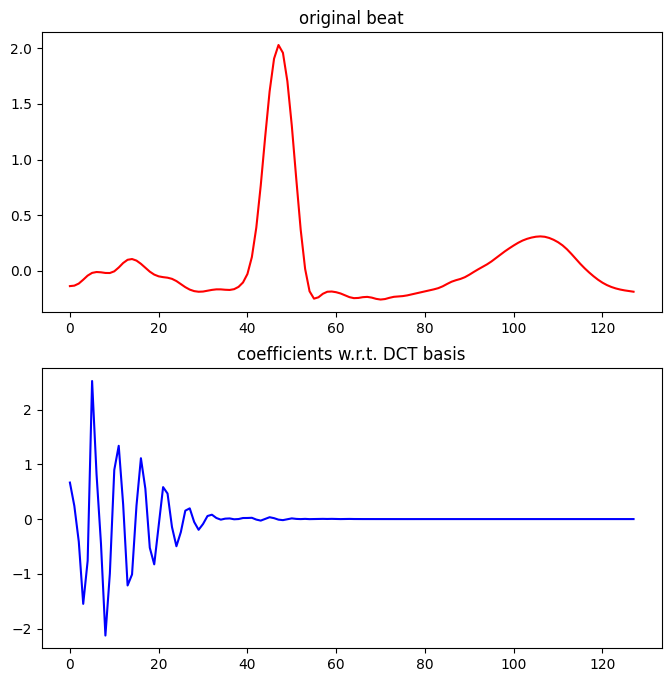

In [31]:
i = 5
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
ax1.plot(S[:, i], 'r')
ax1.set_title('original beat')
ax2.plot(X[:, i], 'b')
ax2.set_title('coefficients w.r.t. DCT basis')

Synthesis: reconstruct all the ECG signals from their representations
---------------------------------------------------------------------
Reconstruct the two signals (express them w.r.t. the standard basis)

In [32]:
S_hat_D = D @ X

Check if there is perfect reconstruction.

It is trivial because $\hat S_D = DD^TS$ and $DD^T = I_M$  since $D$ is orthonormal (the same applies to $C$)

In [33]:
is_reconstruction_perfect = np.allclose(S, S_hat_D, atol = 0) # set the tolerance to 0 to check for perfect reconstruction
print(f'The reconstruction is perfect: {is_reconstruction_perfect}')

The reconstruction is perfect: True


Add noise to ECG data and inspect the representations
-----------------------------------------------------


In [34]:
sigma_noise = 0.1
S0 = S.copy()
S = S0 + sigma_noise * np.random.normal(size=S0.shape)

X = np.zeros((M, nBeats)) # initialize the matrix of representations of S w.r.t. D


Compute the representation coefficients

In [35]:
for i in range(nBeats):
    X[:, i] = D.T @ S[:, i]

Display a signal and its representation coefficients

Text(0.5, 1.0, 'coefficients w.r.t. DCT basis')

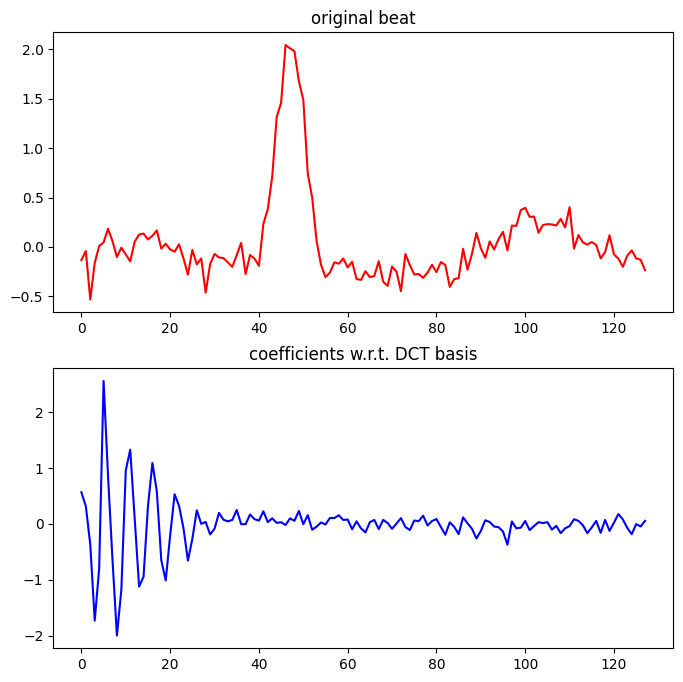

In [36]:
i = 5
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8))
ax1.plot(S[:, i], 'r')
ax1.set_title('original beat')
ax2.plot(X[:, i], 'b')
ax2.set_title('coefficients w.r.t. DCT basis')

Hard Thresholding
-----------------
Noise affects all the coefficients of our transformation

Keep only $L$ coefficients having largest magnitude

In [37]:
X_HT = np.zeros((M, nBeats)) # initialize the matrix of representations of S w.r.t. D
S_hat = np.zeros((M, nBeats))
L = 18 # sparsity level (try different values)
origSignal = S0
noisySignal = S

for i in range(nBeats):
    # transform each signal separately (analysis)
    x = D.T @ S[:,i]

    # keep only the L largest coefficients (absolute value)
    #indices = np.argsort(-np.abs(x)) #indeces of elements of x sorted in desc order
    #X_HT[indices[1:L], i] = x[indices[1:L]] # I sobstitute only the elements with gratest values and keep to 0 the other elements
    L_largest_indices = np.argpartition(np.abs(x), -L)[-L:]
    mask = np.isin(np.arange(x.size), L_largest_indices)
    x_HT = np.copy(x)
    x_HT[~mask] = 0
    
    # invert the transformation
    s_hat = D @ x_HT
    
    X_HT[:,i] = x_HT 
    S_hat[:, i] = s_hat

Display a signal

Text(0.5, 1.0, 'DCT coefficients')

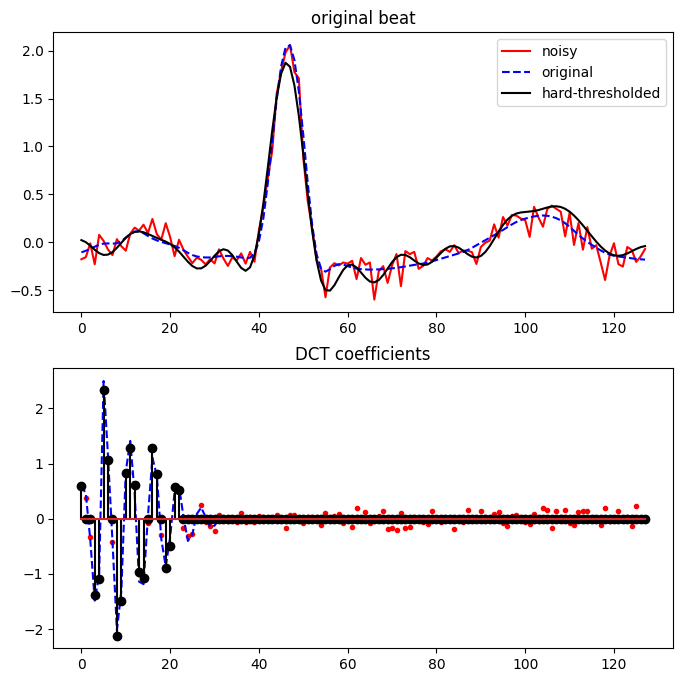

In [38]:
i = 9
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8))
ax1.plot(S[:, i], 'r')
ax1.plot(S0[:, i], 'b--')
ax1.plot(S_hat[:, i], 'k')
ax1.legend(['noisy', 'original', 'hard-thresholded'])
ax1.set_title('original beat')

# coefficients of the noisy signal
ax2.plot(np.matmul(D.T, S[:, i]), 'r.')
# coefficients of the noise free signal
ax2.plot(np.matmul(D.T, S0[:, i]), 'b--')
ax2.stem(np.arange(M), X_HT[:, i], 'k')
ax2.set_title('DCT coefficients')

Compression
-----------
Try to compress a heartbeat using different value of $L$ and plot the mean squared error corresponding to each $L$

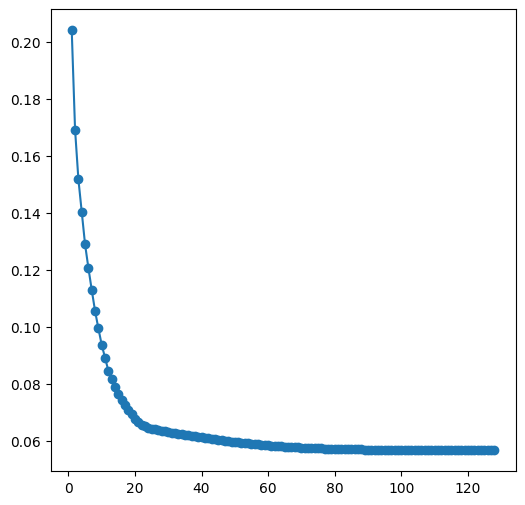

In [39]:
x_HT = np.zeros((M)) # initialize the matrix of representations of S w.r.t. D
s_hat = np.zeros((M))

L_values = np.arange(1, M+1)
MSE_values = np.zeros(M)

i = 0 #signal on which we compute the mean squared errors
origSignal = S[:, i]

for L in L_values:
    # transform each signal separately (analysis)
    x = np.dot(np.transpose(D), S[:,i])

    # keep only the L largest coefficients (absolute value)
    indices = np.argsort(-np.abs(x)) #indeces of elements of x sorted in desc order
    x_HT[indices[1:L]] = x[indices[1:L]] # the rest of the elements are set to zero in the definition 

    # invert the transformation
    s_hat = np.dot(D, x_HT)

    diff = s_hat - origSignal
    mse = np.dot(np.transpose(diff), diff) / M

    MSE_values[L-1] = mse

plt.figure(figsize=(6,6))
plt.plot(L_values, MSE_values, '-o')